In [1]:
#Se cargan las bibliotecas necesarias 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage. feature import hog
import matplotlib.image as mpimg

from sklearn import svm
import numpy as np
import joblib
from skimage.feature import hog
from sklearn.utils import shuffle
import sys
import argparse
import random

In [2]:
import glob
# Obtenemos una lista de rutas de archivos .jpg en la carpeta "data_svm/Pedestrian"
pedestrian = glob.glob("data_svm/Pedestrian/*.png")
# Obtenemos una lista de rutas de archivos .jpg en la carpeta "data_svm/nonPedestrian"
no_pedestrian= glob.glob("data_svm/nonPedestrian/*.png")

In [3]:
# Obtenemos la longitud de la lista "pedestrian"
len(pedestrian)

614

In [4]:
# Obtenemos la longitud de la lista "no_pedestrian"
len(no_pedestrian)

912

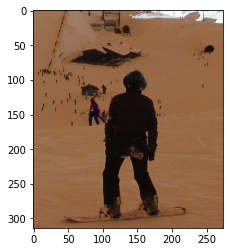

In [5]:
# Leemos una imagen en color utilizando la ruta del archivo en la posición 10 de la lista "pedestrian"
img_color= cv2.imread(pedestrian[1])
plt.imshow(img_color)

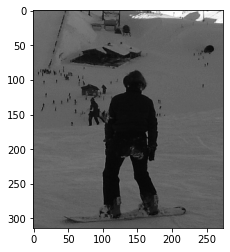

In [6]:
# Convertimos la imagen en color a escala de grises utilizando cv2.cvtColor()
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Mostramos la imagen en escala de grises utilizando plt.imshow()
# Utilizamos el mapa de colores (colormap) 'gray' para representar la imagen en escala de grises
plt.imshow(img_gray, cmap="gray")

In [7]:
def crop_centre(img):
    '''Función para recortar el centro de una imagen'''
    h, w, _ = img.shape
    l = int((w - 64) / 2)  # Calcula la posición izquierda del recorte
    t = int((h - 128) / 2)  # Calcula la posición superior del recorte

    crop = img[t:t+128, l:l+64]  # Recorta la región central de la imagen
    return crop

In [8]:
cropped = crop_centre(img_color)  # Recortamos el centro de la imagen
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)  # Convertimos la imagen recortada a escala de grises
features, hog_img = hog(gray, orientations=11, 
                        pixels_per_cell=(16, 16),
                        cells_per_block=(2, 2),
                        transform_sqrt=False,
                        visualize=True,
                        feature_vector=True)  # Calculamos el Histogram of Oriented Gradients (HOG) de la imagen en escala de grises

In [9]:
print('Dimensiones de los features: ', features.shape)  # Imprimimos las dimensiones de los features del HOG
print('Dimensiones de hot imágenes: ', hog_img.shape)  # Imprimimos las dimensiones de las imágenes del HOG

Dimensiones de los features:  (924,)
Dimensiones de hot imágenes:  (128, 64)


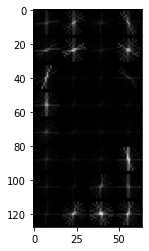

In [10]:
plt.imshow(hog_img, cmap="gray")  # Visualizamos la imagen del HOG en escala de grises

In [11]:
pedestrian_hog_accum = []

# Recorremos la lista de imágenes de peatones
for i in pedestrian:
    img_color = mpimg.imread(i)  # Leemos la imagen en color
    cropped = crop_centre(img_color)  # Recortamos el centro de la imagen
    img_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)  # Convertimos la imagen recortada a escala de grises

    pedestrian_hog_feature = hog(img_gray,
                                orientations=11,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(2, 2),
                                transform_sqrt=False,
                                visualize=False,
                                feature_vector=True)  # Calculamos el HOG de la imagen en escala de grises

    pedestrian_hog_accum.append(pedestrian_hog_feature)  # Agregamos el HOG de la imagen a la lista acumulativa


In [12]:
# Creamos una matriz de características X_pedestrian utilizando las características HOG acumuladas
X_pedestrian = np.vstack(pedestrian_hog_accum).astype(np.float64)

# Creamos un arreglo de etiquetas Y_pedestrian con valor 1 para cada muestra de peatón
Y_pedestrian = np.ones(len(X_pedestrian))

In [13]:
print('Dimensiones de X pedestrian: ', X_pedestrian.shape) # Obtenemos la forma (shape) de la matriz de características X_pedestrian
print('Dimensiones de Y pedestrian: ', Y_pedestrian.shape) # Obtenemos la forma (shape) de la matriz de características Y_pedestrian

Dimensiones de X pedestrian:  (614, 924)
Dimensiones de Y pedestrian:  (614,)


In [14]:
nopedestrian_hog_accum = []

# Recorremos la lista de imágenes sin peatones
for i in no_pedestrian:
    img_color = mpimg.imread(i)  # Leemos la imagen en color
    cropped = crop_centre(img_color)  # Recortamos el centro de la imagen
    img_gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)  # Convertimos la imagen recortada a escala de grises

    nopedestrian_hog_feature = hog(img_gray,
                                   orientations=11,
                                   pixels_per_cell=(16, 16),
                                   cells_per_block=(2, 2),
                                   transform_sqrt=False,
                                   visualize=False,
                                   feature_vector=True)  # Calculamos el HOG de la imagen en escala de grises

    nopedestrian_hog_accum.append(nopedestrian_hog_feature)  # Agregamos el HOG de la imagen a la lista acumulativa


In [15]:
X_nopedestrian = np.vstack(nopedestrian_hog_accum).astype(np.float64)  # Concatenamos verticalmente los descriptores HOG de las imágenes sin peatones
Y_nopedestrian = np.zeros(len(X_nopedestrian))  # Creamos un arreglo de etiquetas para las imágenes sin peatones


In [16]:
print('Dimensiones de X nonPedestrian: ', X_nopedestrian.shape)  # Imprimimos las dimensiones de X_nopedestrian
print('Dimensiones de Y nonPedestrian: ', Y_nopedestrian.shape)  # Imprimimos las dimensiones de Y_nopedestrian

Dimensiones de X nonPedestrian:  (912, 924)
Dimensiones de Y nonPedestrian:  (912,)


In [17]:
# Concatenamos verticalmente las matrices X_pedestrian y X_nopedestrian para formar la matriz X
X = np.vstack((X_pedestrian, X_nopedestrian))

# Obtenemos la forma (shape) de la matriz X
X.shape

(1526, 924)

In [18]:
# Concatenamos horizantalmente los arreglos Y_pedestrian y Y_nopedestrian para formar el arreglo Y
Y = np.hstack((Y_pedestrian, Y_nopedestrian))

# Obtenemos la forma (shape) del arreglo Y
Y.shape

(1526,)

In [19]:
# Se generan los datos de entrenamiento y prueba utilizando la función train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
print('Dimensiones de X train: ', X_train.shape) # Obtenemos la forma (shape) de X_train
print('Dimensiones de X test: ', X_test.shape) # Obtenemos la forma (shape) de X_test

Dimensiones de X train:  (1220, 924)
Dimensiones de X test:  (306, 924)


In [21]:
print('Dimensiones de y train: ', y_train.shape) # Obtenemos la forma (shape) de y_train
print('Dimensiones de y test: ', y_test.shape) # Obtenemos la forma (shape) de y_test

Dimensiones de y train:  (1220,)
Dimensiones de y test:  (306,)


In [22]:
from sklearn.svm import SVC

# Creamos una instancia del modelo de clasificación SVC (Support Vector Classifier)
svc_model = SVC()

# Entrenamos el modelo utilizando los conjuntos de datos de entrenamiento X_train y y_train
svc_model.fit(X_train, y_train)

SVC()

In [23]:
# Realizamos predicciones en los datos de prueba utilizando el modelo entrenado
y_predict = svc_model.predict(X_test)

<AxesSubplot:>

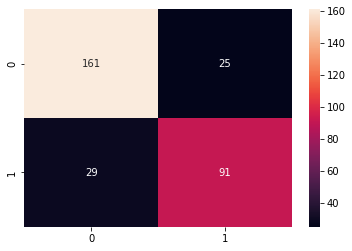

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculamos la matriz de confusión utilizando las etiquetas reales y las predichas
cm = confusion_matrix(y_test, y_predict)

# Visualizamos la matriz de confusión utilizando un mapa de calor (heatmap) y anotaciones
sns.heatmap(cm, annot=True, fmt="d")

In [25]:
# Imprimimos un informe de clasificación que muestra métricas de evaluación detalladas
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       186
         1.0       0.78      0.76      0.77       120

    accuracy                           0.82       306
   macro avg       0.82      0.81      0.81       306
weighted avg       0.82      0.82      0.82       306



In [26]:
# Define los hiperparámetros y los posibles valores 
# que se utilizarán en la búsqueda de la mejor combinación de hiperparámetros para el modelo de clasificación.
param_grid = {'C': [0.1,1,10,100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel':['rbf']}

In [27]:
from sklearn.model_selection import GridSearchCV

# Creamos una instancia de GridSearchCV para buscar los mejores hiperparámetros
# Utilizamos SVC() como estimador base, param_grid como el espacio de búsqueda de hiperparámetros
# refit=True indica que se ajustará el modelo final con la mejor combinación de hiperparámetros
# verbose=4 proporciona mensajes detallados durante el proceso de búsqueda
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)

# Realizamos la búsqueda de hiperparámetros utilizando los conjuntos de datos de entrenamiento
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.598 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.648 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.639 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.627 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.627 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.594 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.594 total time=   0.3s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.598 total time=   0.3s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.787 total time=   0.3s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.811 total time=   0.3s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.783 total time=   0.3s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.799 total time=   0.3s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.799 total time=   0.3s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.738 total time=   0.2s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.713 total time=   0.2s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.762 total time=   0.2s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [28]:
# Obtenemos los mejores hiperparámetros encontrados durante la búsqueda
print('El mejor parámetro para nuestro set es: ', grid.best_params_)
# Obtenemos el mejor estimador (modelo) encontrado durante la búsqueda
print('El mejor estimador para nuestro set es: ', grid.best_estimator_)

El mejor parámetro para nuestro set es:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
El mejor estimador para nuestro set es:  SVC(C=10, gamma=0.1)


In [29]:
# Realizamos predicciones en los datos de prueba utilizando el mejor modelo encontrado durante la búsqueda
grid_predictions = grid.predict(X_test)

<AxesSubplot:>

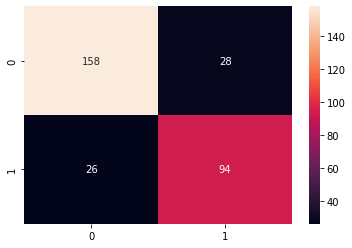

In [30]:
# Calculamos la matriz de confusión utilizando las etiquetas reales y las predicciones del mejor modelo
cm = confusion_matrix(y_test, grid_predictions)

# Visualizamos la matriz de confusión utilizando un mapa de calor (heatmap) y anotaciones
sns.heatmap(cm, annot=True, fmt="d")

In [31]:
# Imprimimos un informe de clasificación que muestra métricas de evaluación detalladas del mejor modelo
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85       186
         1.0       0.77      0.78      0.78       120

    accuracy                           0.82       306
   macro avg       0.81      0.82      0.82       306
weighted avg       0.82      0.82      0.82       306

